In [1]:
import pandas as pd 
import numpy as np 
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data

In [3]:
df_train = pd.read_csv('mnist kaggle\mnist_train.csv')
df_test = pd.read_csv('mnist kaggle\mnist_test.csv')

df_train.head()


,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_labels = df_train.iloc[:, 0]
train_images = df_train.iloc[:, 1:]

test_labels = df_test.iloc[:, 0]
test_images = df_test.iloc[:, 1:]

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms

    def __getitem__(self, i):
        data = self.X.iloc[i, :]
        data = np.array(data).astype('float32').reshape(1, 28, 28)

        if self.transforms:
            data = self.transforms(data)
        
        if self.y is not None:
            return (data, self.y[i])
        
        else:
            return data

    def __len__(self):
        return (len(self.X))

In [6]:
class toTensor(object):
    def __call__(self, image):
        img = torch.from_numpy(image)
        return img


In [7]:
transform = transforms.Compose([toTensor()])

In [8]:
train_dataset = CustomDataset(train_images, train_labels, transforms=None)
val_dataset = CustomDataset(test_images, test_labels, transforms=transform)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128)

In [10]:
data_iter = iter(train_loader)
# Mini-batch images and labels
images, labels = next(data_iter)

images.type()

'torch.FloatTensor'

# Build model

In [11]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(7*7*32, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)

        return out

In [12]:
model = ConvNet(10).to(device)
total_paras = sum(p.numel() for p in model.parameters())
trainable_paras = sum(p.numel() for p in model.parameters() if p.requires_grad)


print(model)
print('Trainable params = ',trainable_paras)
print('Total params = ', total_paras)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
Trainable params =  29034
Total params =  29034


# Loss and Optimizer

In [13]:
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [14]:

train_loss_values = []
val_acc_values = []
val_loss_values = []
best_acc = 0

for epoch in range(10):
    train_loss = 0
    val_loss = 0
    correct = 0

    #Training
    for (images, labels) in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        model.train()
        outputs = model(images)
        loss = loss_func(outputs, labels)

        #Backward
        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    train_loss_values.append(train_loss)

    #Validating
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        model.eval()
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        loss = loss_func(outputs, labels)
        
        val_loss += loss.item()
        correct += torch.sum(pred == labels.data).cpu()

    val_loss = val_loss / len(val_loader)
    val_loss_values.append(val_loss)

    val_acc = correct / len(val_dataset)
    val_acc_values.append(val_acc)

    print('Epoch [{}]: train_loss = {:.4f}, val_loss = {:.4f}, val_acc = {:.4f}.'.format(epoch+1, train_loss, val_loss, val_acc))

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'mnist kaggle\\best.ckpt')
        print('Save best!')
    print('-'*20)

print('Best weights is stored in: "mnist kaggle\\best.ckpt" with acc= {}'.format(best_acc))


C:\Users\dangv\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1]: train_loss = 0.1679, val_loss = 0.0519, val_acc = 0.9832.
Save best!
--------------------
Epoch [2]: train_loss = 0.0515, val_loss = 0.0521, val_acc = 0.9837.
Save best!
--------------------
Epoch [3]: train_loss = 0.0374, val_loss = 0.0405, val_acc = 0.9871.
Save best!
--------------------
Epoch [4]: train_loss = 0.0295, val_loss = 0.0399, val_acc = 0.9863.
--------------------
Epoch [5]: train_loss = 0.0253, val_loss = 0.0431, val_acc = 0.9883.
Save best!
--------------------
Epoch [6]: train_loss = 0.0213, val_loss = 0.0445, val_acc = 0.9868.
--------------------
Epoch [7]: train_loss = 0.0184, val_loss = 0.0282, val_acc = 0.9905.
Save best!
--------------------
Epoch [8]: train_loss = 0.0145, val_loss = 0.0322, val_acc = 0.9899.
--------------------
Epoch [9]: train_loss = 0.0118, val_loss = 0.0346, val_acc = 0.9911.
Save best!
--------------------
Epoch [10]: train_loss = 0.0136, val_loss = 0.0316, val_acc = 0.9901.
--------------------
Best weights is stored in: "mnist

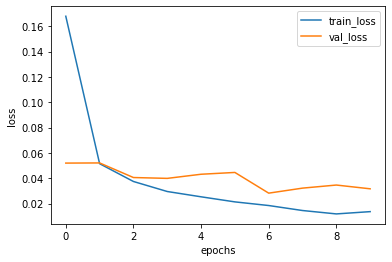

In [15]:
# fig = plt.figure()
plt.plot(train_loss_values, label='train_loss')
plt.plot(val_loss_values, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# Test

In [16]:
# model.load_state_dict(torch.load('mnist kaggle\\best.ckpt'))
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in val_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += torch.sum(predicted == labels)

#     print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

In [17]:
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([12.7673, 14.1737, 14.7711, 19.5018, 14.9774, 17.2811, 10.0301, 10.4374,
         4.4591, 10.5845, 17.2667, 15.4574, 14.8740, 14.4923, 11.8900],
       device='cuda:0'),
indices=tensor([2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0'))

# Predict

labels:  tensor(3, device='cuda:0')
pred:  tensor(5, device='cuda:0')


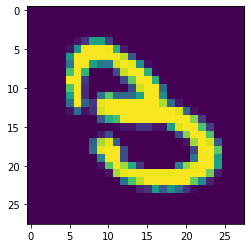

labels:  tensor(9, device='cuda:0')
pred:  tensor(5, device='cuda:0')


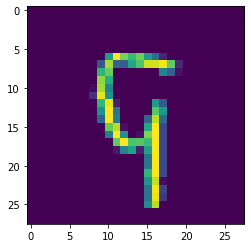

In [18]:
test_iter = iter(val_loader)
# Mini-batch images and labels
images, labels = next(test_iter)
images = images.to(device)
labels = labels.to(device)

out = model(images)
_, pred = torch.max(out.data, 1)

#In ra cacs ket qua sai
for i in range(128):
    if labels[i] != pred[i]:
        print('labels: ', labels[i])
        print('pred: ', pred[i])
        img = images[i].cpu()
        img = np.transpose(img, (1,2,0))
        plt.imshow(img)
        plt.show()

In [19]:
torch.sum(labels == pred)

tensor(126, device='cuda:0')

tensor(1, device='cuda:0')
tensor(1, device='cuda:0')


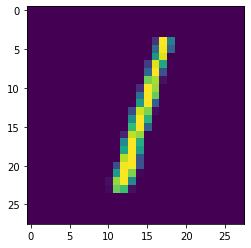

tensor(2, device='cuda:0')
tensor(2, device='cuda:0')


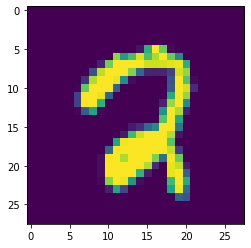

tensor(7, device='cuda:0')
tensor(7, device='cuda:0')


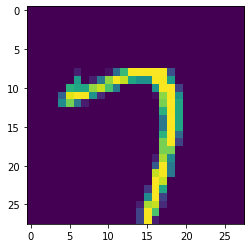

tensor(3, device='cuda:0')
tensor(3, device='cuda:0')


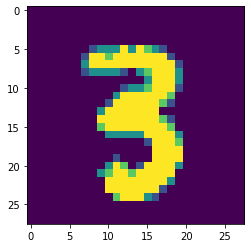

tensor(9, device='cuda:0')
tensor(9, device='cuda:0')


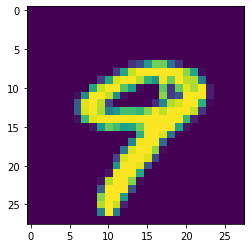

In [20]:
for _ in range(5):
    i = random.randint(0, 127)
    print(labels[i])
    print(pred[i])
    plt.imshow(np.transpose(images[i].cpu(), (1,2,0)))
    plt.show()